In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import pickle
from torch.utils.data import Dataset
import random

In [2]:
seed = 100
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda')
device

device(type='cuda')

In [4]:
with open('train.pkl', 'rb') as f:
    pck_data = pickle.load(f)

random.shuffle(pck_data)

{3: 441, 1: 478, 0: 1630, 4: 236, 2: 154}


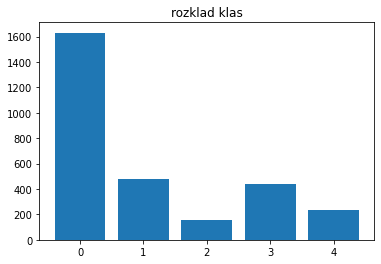

In [5]:
counts = {}
for record in pck_data:
    if record[1] in counts:
        counts[record[1]] += 1
    else:
        counts[record[1]] = 1
print(counts)

plt.bar(list(counts.keys()), list(counts.values()))
plt.title("rozklad klas")
plt.show()

In [6]:
data = []
targets = []
max_val = float("-inf")
min_val = float("inf")
for record in pck_data:
    data.append(torch.from_numpy(np.array(record[0])))
    targets.append(torch.from_numpy(np.array(record[1])))
    max_val = data[-1].max() if data[-1].max() > max_val else max_val
    min_val = data[-1].min() if data[-1].min() < min_val else min_val

max_val, min_val

(tensor(191., dtype=torch.float64), tensor(-1., dtype=torch.float64))

In [7]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [8]:
train_indices = int(len(data) * 0.75)
data = [( (x - min_val) / (max_val-min_val) - 0.5).float() for x in data]
train_set = VariableLenDataset(data[:train_indices], targets[:train_indices])
test_set = VariableLenDataset(data[train_indices:], targets[train_indices:])

In [9]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = -1

def pad_collate(batch, pad_value=-1):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    return xx_pad, torch.Tensor(yy), torch.Tensor(x_lens)

In [10]:
batch_size = 40
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=pad_collate)
torch.set_printoptions(profile="default")
for a,b,c in test_loader:
    print(a[30])
    break

tensor([ 0.0260, -0.0938, -0.1615,  ..., -1.0000, -1.0000, -1.0000])


In [11]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, batch_size,bidirectional = False):
        super().__init__()
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=0.2)
        self.fc1 = nn.Linear( (3*hidden_size*self.bidirectional), (3*hidden_size*self.bidirectional) // 2 )
        self.bn1 = nn.BatchNorm1d((3*hidden_size*self.bidirectional) // 2)
        self.act1 = nn.ReLU()
        self.d1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear((3*hidden_size*self.bidirectional) // 2, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden, lens_x):
        curr_b = x.shape[0]
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        out = torch.zeros((curr_b, 3*self.bidirectional*self.hidden_size), requires_grad=True).to(device)
        for i in range(curr_b):
          idx1 = lens_x[i]-3
          idx2 = lens_x[i]
          out[i, :] = all_outputs[i, idx1:idx2, :].flatten()
        x = self.fc1(out)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.d1(x)
        x = self.fc2(x)
        return x, hidden

In [16]:

#torch.set_printoptions(profile="full")


model = LSTMClassifier(1, 256, 2, 5, batch_size, False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fun = nn.CrossEntropyLoss(weight=torch.Tensor([1, 2, 3, 2, 3]).to(device), reduction='mean')

In [17]:
import sys
model.train()

losses_train = []
losses_epoch_train = []
losses_test = []
losses_epoch_test = []

acc_train = []
acc_epoch_train = []
acc_test = []
acc_epoch_test = []


for epoch in range(25):
    model.train()
    for x, targets, lens in train_loader:
        targets = targets.long()
        x = x.to(device).unsqueeze(2)
        lens = lens.long().to(device)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden,state), lens)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses_epoch_train.append(loss.item())
        acc = (preds.argmax(dim=1) == targets).sum() / preds.shape[0]
        acc_epoch_train.append(acc.cpu())
    losses_train.append(np.mean(losses_epoch_train))
    acc_train.append(np.mean(acc_epoch_train))

    model.eval()
    with torch.no_grad():
        for x, targets, lens in test_loader:
            targets = targets.long()
            x = x.to(device).unsqueeze(2)
            lens = lens.long().to(device)
            targets = targets.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = model(x, (hidden,state), lens)
            losses_epoch_test.append(loss.item())
            acc = (preds.argmax(dim=1) == targets).sum() / preds.shape[0]
            acc_epoch_test.append(acc.cpu())
    losses_test.append(np.mean(losses_epoch_test))
    acc_test.append(np.mean(acc_epoch_test))
    print(f"Epoch: {epoch}, loss train: {losses_train[-1]:.3}, loss test: {losses_test[-1]:.3}")
    print(f"Epoch: {epoch}, acc train: {acc_train[-1]:.3}, acc test: {acc_test[-1]:.3}")

Epoch: 0, loss train: 1.71, loss test: 1.33
Epoch: 0, acc train: 0.365, acc test: 0.169
Epoch: 1, loss train: 1.67, loss test: 1.41
Epoch: 1, acc train: 0.388, acc test: 0.363
Epoch: 2, loss train: 1.64, loss test: 1.38
Epoch: 2, acc train: 0.407, acc test: 0.416
Epoch: 3, loss train: 1.63, loss test: 1.46
Epoch: 3, acc train: 0.418, acc test: 0.432
Epoch: 4, loss train: 1.62, loss test: 1.47
Epoch: 4, acc train: 0.43, acc test: 0.43
Epoch: 5, loss train: 1.61, loss test: 1.47
Epoch: 5, acc train: 0.434, acc test: 0.427
Epoch: 6, loss train: 1.6, loss test: 1.42
Epoch: 6, acc train: 0.443, acc test: 0.448
Epoch: 7, loss train: 1.58, loss test: 1.48
Epoch: 7, acc train: 0.455, acc test: 0.446
Epoch: 8, loss train: 1.56, loss test: 1.49
Epoch: 8, acc train: 0.463, acc test: 0.438
Epoch: 9, loss train: 1.54, loss test: 1.42
Epoch: 9, acc train: 0.466, acc test: 0.453
Epoch: 10, loss train: 1.52, loss test: 1.4
Epoch: 10, acc train: 0.471, acc test: 0.455
Epoch: 11, loss train: 1.51, loss 

Finished Training


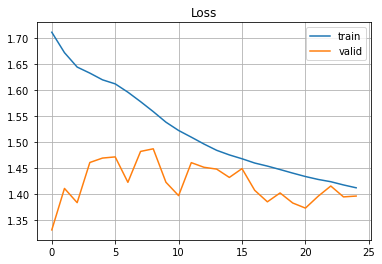

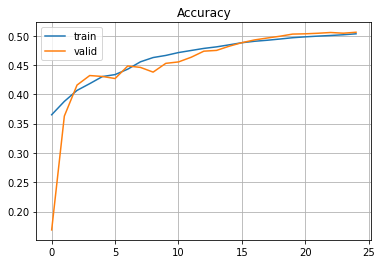

In [18]:
plt.figure()
plt.grid(True)
plt.plot(losses_train)
plt.plot(losses_test)
plt.title("Loss")
plt.legend(["train", "valid"])

plt.figure()
plt.grid(True)
plt.title("Accuracy")
plt.plot(acc_train)
plt.plot(acc_test)
plt.legend(["train", "valid"])
print('Finished Training')

In [19]:
correct_preds = [0 for _ in range(5)]
total_preds = [0 for _ in range(5)]


model.eval()
with torch.no_grad():
    for x, targets, lens in test_loader:
        targets = targets.long()
        x = x.to(device).unsqueeze(2)
        lens = lens.long().to(device)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden,state), lens)
        losses_epoch_test.append(loss.item())
        acc = (preds.argmax(dim=1) == targets).sum() / preds.shape[0]
        acc_epoch_test.append(acc.cpu())


        _, max_preds = torch.max(preds, 1)
        for label, prediction in zip(targets, max_preds):
          label = label.item()
          if label == prediction:
              correct_preds[label] += 1
          total_preds[label] += 1


print(f"Acc: {np.mean(acc_epoch_test)}")

class_accs = []
for i, correct_count in enumerate(correct_preds):
    accuracy = 100 * float(correct_count) / total_preds[i]
    print(f"Accuracy for class {i} is: {accuracy} %")
    class_accs.append(accuracy)

print(f"Avg class acc: {np.array(class_accs).mean()}")

Acc: 0.5073380470275879
Accuracy for class 0 is: 69.19315403422983 %
Accuracy for class 1 is: 61.666666666666664 %
Accuracy for class 2 is: 0.0 %
Accuracy for class 3 is: 28.09917355371901 %
Accuracy for class 4 is: 27.272727272727273 %
Avg class acc: 37.246344305468554


In [107]:
# Predykcje dla zbioru testowego
predictions = []
composers = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
with open('test_no_target.pkl', 'rb') as f:
    pck_data_test = pickle.load(f)
print(len(pck_data_test))

1103


In [108]:
data_test = []
targets = []
for record in pck_data_test:
    data_test.append(torch.from_numpy(np.array(record)))
    targets.append(torch.Tensor([-10]))

data_test = [( (x - min_val) / (max_val-min_val) - 0.5).float() for x in data_test]
test_set = VariableLenDataset(data_test, targets)
test_loader = DataLoader(test_set, batch_size=batch_size, collate_fn=pad_collate)

for a,b,c in test_loader:
  print(a[0])
  break

tensor([-0.4948, -0.4948, -0.4948,  ..., -1.0000, -1.0000, -1.0000])


In [109]:
predictions = []
model.eval()
with torch.no_grad():
    for x, targets, lens in test_loader:
        x = x.to(device).unsqueeze(2)
        lens = lens.long().to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden,state), lens)
        preds = preds.argmax(dim=1)
        predictions.append(preds.cpu().detach().numpy())

predictions = np.concatenate(predictions, axis=0)

pred_composers = []
for pred in predictions:
  pred_composers.append(composers[pred])

pred_composers

['debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'bach',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'bach',
 'bach',
 'debussy',
 'bach',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'debussy',
 'bach',
 'debus